In [1]:
#from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
from collections import deque
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from operator import itemgetter 

In [2]:
def get_ratio(country, adr, fx_dict):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open'})
    fx_df = pd.read_csv(fx_path, index_col = 0)

    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close']], stock_df.loc[:,['date', 'stock_open','stock_close']])
    merged_df = pd.merge(merged_df, fx_df)

    if fx_type == 1:
        merged_df['stock_open_usd'] = merged_df['stock_open']/((merged_df['avg_bid_non_us_at'] + merged_df['avg_ask_non_us_at'])/2)
    else:
        merged_df['stock_open_usd'] = merged_df['stock_open']*((merged_df['avg_bid_non_us_at'] + merged_df['avg_ask_non_us_at'])/2)
    merged_df["ratio"] = merged_df['stock_open_usd']/merged_df['adr_close']
    
    ratio_geq_1 = True
    if np.mean(merged_df["ratio"] < 1):
        merged_df["ratio"] = 1/merged_df["ratio"]
        ratio_geq_1 = False
    
    return ratio_geq_1, np.round(np.mean(merged_df["ratio"]), 4)

In [4]:
mypath = 'eric_jh_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f)) and f != ".ipynb_checkpoints"] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))
        
# Store ratios
for (country, adr) in list_pairs:
    ratio_geq_1, ratio = get_ratio(country, adr, fx_dict)
    if adr == "ACH_2600" or adr == "BGNE_6160":
        rounded_ratio = float('%.2g' % ratio)
    else:
        rounded_ratio = float('%.1g' % ratio)
    print("Country: {}, ADR_Stock: {}, Estimated Ratio (4 d.p.): {}, Implied Ratio (2 s.f.): {}".format(country, adr, ratio, rounded_ratio))
    ratio_df = pd.DataFrame({"ratio_geq_1" : [ratio_geq_1], "ratio" : [rounded_ratio]})
    ratio_df.to_csv(f'eric_jh_data/{country}/{adr}/ratio.csv')
        
# This shows the empircally estimated ratio, and the implied ratio we shall assume.
# These values corroborate with the select few we checked online, like GENE_GTG and BGNE_6160.

Country: Australia, ADR_Stock: ATHE_ATH, Estimated Ratio (4 d.p.): 59.4889, Implied Ratio (2 s.f.): 60.0
Country: Australia, ADR_Stock: GENE_GTG, Estimated Ratio (4 d.p.): 595.5978, Implied Ratio (2 s.f.): 600.0
Country: Australia, ADR_Stock: IMMP_IMM, Estimated Ratio (4 d.p.): 9.9082, Implied Ratio (2 s.f.): 10.0
Country: Australia, ADR_Stock: IMRN_IMC, Estimated Ratio (4 d.p.): 39.4289, Implied Ratio (2 s.f.): 40.0
Country: Australia, ADR_Stock: JHX_JHX, Estimated Ratio (4 d.p.): 1.0043, Implied Ratio (2 s.f.): 1.0
Country: Australia, ADR_Stock: KZIA_KZA, Estimated Ratio (4 d.p.): 10.0346, Implied Ratio (2 s.f.): 10.0
Country: Australia, ADR_Stock: MESO_MSB, Estimated Ratio (4 d.p.): 5.0155, Implied Ratio (2 s.f.): 5.0
Country: Australia, ADR_Stock: PLL_PLL, Estimated Ratio (4 d.p.): 101.5788, Implied Ratio (2 s.f.): 100.0
Country: Australia, ADR_Stock: WBK_WBC, Estimated Ratio (4 d.p.): 0.9997, Implied Ratio (2 s.f.): 1.0
Country: China, ADR_Stock: ACH_2600, Estimated Ratio (4 d.p.)

In [5]:
def data_processing(country, adr, fx_dict, forex_bps = 10, adjust_forex_expense = True):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    ratio_path = f'eric_jh_data/{country}/{adr}/ratio.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open', 'volume' : 'adr_volume'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open', 'volume' : 'stock_volume'})
    fx_df = pd.read_csv(fx_path, index_col = 0)
    ratio_df = pd.read_csv(ratio_path, index_col = 0)

    # Invert fx data so that all prices are reflected in USD
    if fx_type == 0:
        inverted_fx_df = 1/fx_df.iloc[:,[2,1,4,3,6,5,8,7]].copy()
        inverted_fx_df.columns = fx_df.columns[1:]
        fx_df.iloc[:,1:] = inverted_fx_df
    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close', 'adr_volume']], stock_df.loc[:,['date', 'stock_open','stock_close', 'stock_volume']])
    merged_df = pd.merge(merged_df, fx_df)
    ratio_geq_1, ratio = ratio_df["ratio_geq_1"].item(), ratio_df["ratio"].item()

#     ratio is (stock price in USD)/(ADR price)
#     If ratio >= 1, we shall buy 1 stock, and sell multiple adrs
#     If ratio < 1, we shall sell 1 adr, and buy multiple stocks
    if ratio_geq_1:
        merged_df["stock_num_per_unit"] = 1
        merged_df["adr_num_per_unit"] = ratio
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]*ratio
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]*ratio
    else:
        merged_df["stock_num_per_unit"] = ratio
        merged_df["adr_num_per_unit"] = 1
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]*ratio
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]*ratio
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]    
    
    if adjust_forex_expense:
        # Added expense for trading small amounts in forex market
        forex_bid_multiplier = 1 - 0.0001*forex_bps
        forex_ask_multiplier = 1 + 0.0001*forex_bps
        merged_df.loc[:,merged_df.columns.str.contains("bid")] *= forex_bid_multiplier
        merged_df.loc[:,merged_df.columns.str.contains("ask")] *= forex_ask_multiplier
        
    return merged_df

In [6]:
# stock_num_per_unit is how many stocks we would buy for 1 "unit" of trade
# avg_bid_non_us_before is how much foreign currency we can buy with 1 USD, 1 minute before the Asian market opens
# avg_bid_non_us_at is how much foreign currency we can buy with 1 USD, when the Asian market opens
# avg_bid_us_before is how much foreign currency we can buy with 1 USD, 1 minute before the US market opens
# avg_bid_us_at is how much foreign currency we can buy with 1 USD, when the US market opens
# All dates are in local time: so in sequential order (for each row), it will go stock_open, stock_close, adr_open, adr_close
merged_df = data_processing(country, adr, fx_dict)
merged_df.tail()

,date,adr_open,adr_close,adr_volume,stock_open,stock_close,stock_volume,avg_bid_non_us_before,avg_ask_non_us_before,avg_bid_non_us_at,...,avg_bid_us_before,avg_ask_us_before,avg_bid_us_at,avg_ask_us_at,stock_num_per_unit,adr_num_per_unit,stock_open_per_unit,stock_close_per_unit,adr_open_per_unit,adr_close_per_unit
1408,2021-04-01,153.60,154.16,1739,8694.0,8423.0,6471600,110.649240,110.872762,110.634255,...,110.518371,110.740630,110.515374,110.737627,2.0,1,17388.0,16846.0,153.60,154.16
1409,2021-04-05,154.16,155.38,1838,8495.0,8461.0,3331600,110.560329,110.783673,110.561328,...,110.322567,110.544434,110.314575,110.537427,2.0,1,16990.0,16922.0,154.16,155.38
1410,2021-04-06,153.10,153.65,2494,8570.0,8366.0,4527100,110.080809,110.302192,110.086803,...,109.666224,109.886777,109.680210,109.900791,2.0,1,17140.0,16732.0,153.10,153.65
1411,2021-04-07,154.84,154.70,1282,8474.0,8487.0,4666500,109.685205,109.905796,109.680210,...,109.671219,109.891782,109.676214,109.896787,2.0,1,16948.0,16974.0,154.84,154.70
1412,2021-04-08,154.35,153.38,1504,8498.0,8418.0,3617000,109.744146,109.964855,109.759131,...,109.007883,109.227118,109.011879,109.231122,2.0,1,16996.0,16836.0,154.35,153.38


In [7]:
def calc_max_drawdown(portfolio_values, method = "percentage"):
    peak, trough = portfolio_values[0], portfolio_values[0]
    max_drawdown = 0
    for i in range(1, len(portfolio_values)):
        if portfolio_values[i] < trough:
            trough = portfolio_values[i]
            if method == "percentage":
                max_drawdown = max(max_drawdown, (peak - trough)/peak)
            else:
                max_drawdown = max(max_drawdown, peak - trough)
        elif portfolio_values[i] > peak:
            peak, trough = portfolio_values[i], portfolio_values[i]
    return max_drawdown

In [8]:
def get_risk_statistics(stock_values, adr_values, var_ci):
    port_stock = stock_values - adr_values
    port = pd.DataFrame(data = port_stock)
    port_diff = port - port.shift(1)
    pnl = pd.DataFrame(port_diff).dropna()
    sigma = pnl.std()[0]
    pnl['pct_rank'] = pnl.rank(pct=True)
    pnl.columns =['daily_pl', 'pct_rank']
    var = abs(pnl[pnl.pct_rank< 1-var_ci].daily_pl.max())
    max_drawdown_abs = calc_max_drawdown(port_stock, "absolute")
    return sigma, var, max_drawdown_abs

In [9]:
merged_df

,date,adr_open,adr_close,adr_volume,stock_open,stock_close,stock_volume,avg_bid_non_us_before,avg_ask_non_us_before,avg_bid_non_us_at,...,avg_bid_us_before,avg_ask_us_before,avg_bid_us_at,avg_ask_us_at,stock_num_per_unit,adr_num_per_unit,stock_open_per_unit,stock_close_per_unit,adr_open_per_unit,adr_close_per_unit
0,2015-04-13,137.67,137.56,2466,8326.0,8248.0,6695800,120.082797,120.327207,120.078801,...,120.053826,120.296176,120.048831,120.291171,2.0,1,16652.0,16496.0,137.67,137.56
1,2015-04-14,138.69,138.66,1232,8216.0,8285.0,4276300,119.932947,120.177057,119.941938,...,119.317563,119.559440,119.319561,119.560441,2.0,1,16432.0,16570.0,138.69,138.66
2,2015-04-15,139.23,139.08,1313,8250.0,8273.0,4569400,119.331549,119.574455,119.354526,...,119.155725,119.395276,119.140740,119.381262,2.0,1,16500.0,16546.0,139.23,139.08
3,2015-04-16,139.05,138.98,1450,8285.0,8309.0,4242800,119.025855,119.268149,119.023857,...,118.944936,119.184065,118.949931,119.190071,2.0,1,16570.0,16618.0,139.05,138.98
4,2015-04-17,138.99,138.43,2017,8309.0,8297.0,7016400,118.927953,119.169050,118.923957,...,119.011869,119.252133,119.006874,119.247128,2.0,1,16618.0,16594.0,138.99,138.43
5,2015-04-21,141.37,141.33,2087,8324.0,8447.0,8189900,119.097783,119.339220,119.115765,...,119.608272,119.850731,119.616264,119.856737,2.0,1,16648.0,16894.0,141.37,141.33
6,2015-04-22,141.47,141.66,1212,8458.0,8462.0,7740900,119.541339,119.784665,119.526354,...,119.605275,119.846727,119.614266,119.856737,2.0,1,16916.0,16924.0,141.47,141.66
7,2015-04-23,141.16,141.03,2079,8500.0,8478.0,5021600,119.830050,120.071952,119.846034,...,119.903976,120.146026,119.904975,120.147027,2.0,1,17000.0,16956.0,141.16,141.03
8,2015-04-24,141.26,141.21,2371,8456.0,8413.0,4588500,119.450430,119.692573,119.464416,...,119.020860,119.260141,119.029851,119.269150,2.0,1,16912.0,16826.0,141.26,141.21
9,2015-04-27,140.96,140.66,2181,8403.0,8340.0,5780400,118.809072,119.047929,118.806075,...,119.219661,119.460341,119.202678,119.443324,2.0,1,16806.0,16680.0,140.96,140.66


In [12]:
"""
Variant 1 - Begin each trade on Asian market open (Evaluate after US market closes)

To open a position, we check the CLOSE price of adr, compared it to CLOSE px of 
stock of the same row. We buy the stock on the next trading OPEN for Asian/US market

To close a position,  we check the CLOSE price of adr, compared it to CLOSE px of 
stock of the same row. We sell the stock on the next trading next OPEN for Asian/US market

For each row:
    stock_open, stock_close, adr_open, adr_close
    After these 4 events, assess condition (right before the Asian market opens ~ 6.59PM EST)
    Place trade on next row (First trade stock on Asian market open, then trade ADR on US market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date (inclusive), when Asian market opens (EST ~ 7:00 PM)
"""

def pairs_trade_v1(merged_df, lookback = 100, cash = 100000, entry = 1, exit = 0, stop_loss = 3, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                   borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2, 
                   sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash, prev_adr_pos = cash, adr_pos
    holding_period = None
    diff_record_bid = deque(maxlen = lookback)
    diff_record_ask = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []

    for index, row in merged_df.iterrows():

        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                portfolio_values.append(prev_cash + prev_adr_pos*merged_df.loc[index - 1, 'adr_close'] 
                                        + stock_pos*(row['stock_open']/row['avg_ask_non_us_at']))

            diff_record_bid.append(row['adr_close_per_unit'] 
                                   - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
            diff_record_ask.append(row['adr_close_per_unit'] 
                                   - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])

            # We place one trade the day itself (Asian), one trade the day after (US)
            if len(diff_record_bid) < lookback or row["date"] < start_date or merged_df.loc[index+1, "date"] > end_date:
                continue
            
            # Update cash/adr position after portfolio values has been updated
            if stock_pos > 0:
                holding_period += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
            prev_cash, prev_adr_pos = cash, adr_pos

            ask_mean = np.array(diff_record_ask).mean()
            bid_std = np.array(diff_record_bid).std()
            ask_std = np.array(diff_record_ask).std()
            
            # If we have passed the initial lookback window and are in the specified dates
            # enter the position if diff is significant
            if diff_record_bid[-1] > ask_mean + entry*bid_std and diff_record_bid[-1] <= ask_mean + stop_loss*bid_std:
                if stock_pos == 0 and adr_pos == 0:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                    units = int(min((0.5*cash)/row['adr_close_per_unit'],
                                    (0.5*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            continue
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])                        
                    
                    stock_pos += stock_quantity
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                    cash -= stock_px*stock_quantity
                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                    prev_cash, prev_adr_pos = cash, adr_pos
                    
                    adr_pos -= adr_quantity
                    adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                    cash += adr_quantity*adr_px
                    
                    holding_period = 0
                    trade_records.append("Opening positions:\n")
                    # Times in EST
                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                    trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

            # Liquidation condition
            elif (diff_record_ask[-1] < ask_mean + exit*ask_std or 
                  diff_record_bid[-1] > ask_mean + stop_loss*bid_std or 
                  holding_period == maximum_holding_period):
                if stock_pos > 0 and adr_pos < 0 : 
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                    cash += stock_pos*stock_px
                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                    prev_cash, prev_adr_pos = cash, adr_pos
                    
                    adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash
    
    return ret, trade_records, portfolio_values, hits, dates

In [13]:
def report_and_store_statistics(pairs_trade_strategy, filename):
    for (country, adr) in list_pairs:
        merged_df = data_processing(country, adr, fx_dict)
        ret, trade_records, portfolio_values, hits, dates = pairs_trade_strategy(merged_df)
        ret = np.round(ret*100, 2)
        hit_ratio = None
        logs = [f'The return of ADR_underlying pairs trading for {adr} from {country} is {0.00}%, no trades were placed.\n']
        if hits:
            hit_ratio = np.round(np.mean(hits)*100,2)
            max_drawdown = np.round(calc_max_drawdown(portfolio_values)*100,2)
            logs = [f'The return of ADR_underlying pairs trading for {adr} from {country} is {ret}%\nThe hit ratio is {hit_ratio}%\nThe max drawdown is {max_drawdown}%\n']
            print("Country: {}, ADR_Stock: {}, Return: {}%, Hit Ratio: {}%, Max Drawdown: {}%".format(country, adr, ret, hit_ratio, max_drawdown))
        else:
            print("Country: {}, ADR_Stock: {}, Return: {}%, Hit Ratio: None, Max Drawdown: 0.00%".format(country, adr, ret))
        logs = logs + trade_records 
        fname = f'eric_jh_data/{country}/{adr}/' + filename
        f = open(fname, 'w')
        f.writelines(logs)
        f.close()
    return dates, portfolio_values

In [14]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v1, 'logs1.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 6.62%, Hit Ratio: 86.67%, Max Drawdown: 3.21%
Country: Australia, ADR_Stock: GENE_GTG, Return: 14.05%, Hit Ratio: 83.02%, Max Drawdown: 5.63%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 4.07%, Hit Ratio: 77.5%, Max Drawdown: 2.5%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 21.7%, Hit Ratio: 78.95%, Max Drawdown: 0.33%
Country: Australia, ADR_Stock: JHX_JHX, Return: -0.53%, Hit Ratio: 31.82%, Max Drawdown: 0.53%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 7.08%, Hit Ratio: 75.76%, Max Drawdown: 1.73%
Country: Australia, ADR_Stock: MESO_MSB, Return: -1.25%, Hit Ratio: 70.31%, Max Drawdown: 9.83%
Country: Australia, ADR_Stock: PLL_PLL, Return: 28.34%, Hit Ratio: 71.43%, Max Drawdown: 8.0%
Country: Australia, ADR_Stock: WBK_WBC, Return: -0.54%, Hit Ratio: 40.32%, Max Drawdown: 2.87%
Country: China, ADR_Stock: ACH_2600, Return: -0.23%, Hit Ratio: 48.65%, Max Drawdown: 0.53%
Country: China, ADR_Stock: BGNE_6160, Return: 61.75%, 

In [15]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v1, 'logs1.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 6.62%, Hit Ratio: 86.67%, Max Drawdown: 3.21%
Country: Australia, ADR_Stock: GENE_GTG, Return: 14.05%, Hit Ratio: 83.02%, Max Drawdown: 5.63%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 4.07%, Hit Ratio: 77.5%, Max Drawdown: 2.5%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 21.7%, Hit Ratio: 78.95%, Max Drawdown: 0.33%
Country: Australia, ADR_Stock: JHX_JHX, Return: -0.53%, Hit Ratio: 31.82%, Max Drawdown: 0.53%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 7.08%, Hit Ratio: 75.76%, Max Drawdown: 1.73%
Country: Australia, ADR_Stock: MESO_MSB, Return: -1.25%, Hit Ratio: 70.31%, Max Drawdown: 9.83%
Country: Australia, ADR_Stock: PLL_PLL, Return: 28.34%, Hit Ratio: 71.43%, Max Drawdown: 8.0%
Country: Australia, ADR_Stock: WBK_WBC, Return: -0.54%, Hit Ratio: 40.32%, Max Drawdown: 2.87%
Country: China, ADR_Stock: ACH_2600, Return: -0.23%, Hit Ratio: 48.65%, Max Drawdown: 0.53%
Country: China, ADR_Stock: BGNE_6160, Return: 61.75%, 

In [16]:
def plot_returns(dates, portfolio_values, num_xticks = 5):
    plt.plot(portfolio_values)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)// num_xticks)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), rotation = 45)
    plt.show();

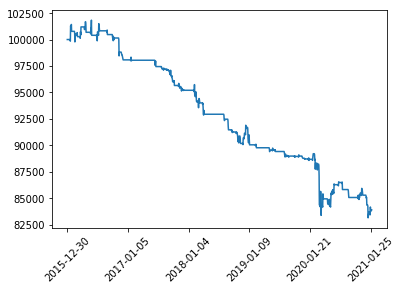

In [17]:
plot_returns(last_dates, last_portfolio_values)

In [18]:
"""
Variant 2 - Begin each trade on US market open (Evaluate after Asian market closes)

To open a position, we check the CLOSE price of adr of the previous row, compared to CLOSE px of 
stock of the current row. We buy the stock on the next trading OPEN for Asian/US market

To close a position, we check the CLOSE price of adr of the previous row, compared to CLOSE px of 
stock of the current row. We sell the stock on the next trading next OPEN for Asian/US market

For each row:
    stock_open, stock_close, (assess), adr_open, adr_close
    After first 2 events events, assess condition (right before the US market opens ~ 9.29AM EST)
    Place trade on current and next row (First trade ADR on US market open, then trade stock on Asian market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date, when the Asian market opens
"""
def pairs_trade_v2(merged_df, lookback = 100, cash = 100000, entry = 1, exit = 0, stop_loss = 3, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                   borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2, 
                   sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    holding_period = None
    # For book-keeping, since we shall store the portfolio value of the day before
    diff_record_bid = deque(maxlen = lookback)
    diff_record_ask = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []

    for index, row in merged_df.iterrows():
        
        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                portfolio_values.append(cash + adr_pos*merged_df.loc[index - 1, 'adr_close'] + stock_pos*(row['stock_open']/row['avg_ask_non_us_at']))

            diff_record_bid.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
            diff_record_ask.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])

            # We place both trades the day itself
            if len(diff_record_bid) < lookback or row["date"] < start_date or row["date"] > end_date:
                continue

            if stock_pos > 0:
                holding_period += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
                
            ask_mean = np.array(diff_record_ask).mean()
            bid_std = np.array(diff_record_bid).std()
            ask_std = np.array(diff_record_ask).std()
            
            # If we have passed the initial lookback window and are in the specified dates
            # enter the position if diff is significant
            if diff_record_bid[-1] > ask_mean + entry*bid_std and diff_record_bid[-1] <= ask_mean + stop_loss*bid_std:
                if stock_pos == 0 and adr_pos == 0:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                    units = int(min((0.5*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                    (0.5*cash)/(row['stock_close_per_unit']/row['avg_bid_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            continue
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])  
                    
                    adr_pos -= adr_quantity
                    adr_px = row['adr_open']*short_multiplier
                    cash += adr_quantity*adr_px
                    
                    stock_pos += stock_quantity
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                    cash -= stock_px*stock_quantity
                    
                    holding_period = 0
                    trade_records.append("Opening positions:\n")
                    # Times in EST
                    trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")

            # Liquidation condition
            elif (diff_record_ask[-1] < ask_mean + exit*ask_std or 
                  diff_record_bid[-1] > ask_mean + stop_loss*bid_std or 
                  holding_period == maximum_holding_period):
                if stock_pos > 0 and adr_pos < 0 : 
                    adr_px = row['adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                    cash += stock_pos*stock_px
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {row['date']}\n")
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash
    
    return ret, trade_records, portfolio_values, hits, dates

In [19]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v2, 'logs2.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 11.56%, Hit Ratio: 80.0%, Max Drawdown: 0.93%
Country: Australia, ADR_Stock: GENE_GTG, Return: 23.36%, Hit Ratio: 79.17%, Max Drawdown: 6.48%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 6.38%, Hit Ratio: 77.78%, Max Drawdown: 1.7%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 3.24%, Hit Ratio: 81.82%, Max Drawdown: 0.09%
Country: Australia, ADR_Stock: JHX_JHX, Return: 0.04%, Hit Ratio: 42.68%, Max Drawdown: 0.2%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 1.5%, Hit Ratio: 72.22%, Max Drawdown: 1.43%
Country: Australia, ADR_Stock: MESO_MSB, Return: 11.35%, Hit Ratio: 75.64%, Max Drawdown: 7.01%
Country: Australia, ADR_Stock: PLL_PLL, Return: 2.8%, Hit Ratio: 77.08%, Max Drawdown: 7.65%
Country: Australia, ADR_Stock: WBK_WBC, Return: 3.18%, Hit Ratio: 48.15%, Max Drawdown: 2.98%
Country: China, ADR_Stock: ACH_2600, Return: 0.04%, Hit Ratio: 45.36%, Max Drawdown: 0.57%
Country: China, ADR_Stock: BGNE_6160, Return: 4.5%, Hit Rat

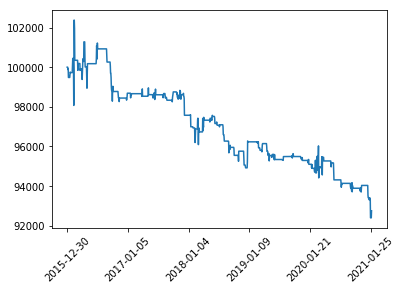

In [20]:
plot_returns(last_dates, last_portfolio_values)

In [21]:
"""
Variant 3a 
- Begin each trade on either US market open or Asian market open
- Regressions are done for the similar "type" of trade
    i.e. if we are entering at a certain time, we do a regression based on the values obtained at the same time each day

For each row:
    stock_open, stock_close, (assess condition 1), adr_open, adr_close, (assess condition 2)
    If not condition 2 - No action taken: 
        After first 2 events, Assess condition 1 (right before the US market opens ~ 9.29AM EST)
        If condition 1:
            Place trade on current and next row (First trade ADR on US market open, then trade stock on Asian market open)
    If not condition 1 - No action taken:
        After next 2 events occur, assess condition 2
        If condition 2:
            Place trade on next row (First trade ADR on Asian market open, then trade stock on US market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date, when the Asian market opens
"""
def pairs_trade_v3a(merged_df, lookback = 100, cash = 100000, entry_cond1_val = 1, entry_cond2_val = 1, 
                    exit_cond1_val = 0, exit_cond2_val = 0, stop_loss_cond1 = 3, stop_loss_cond2 = 3, 
                    start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                    borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2, 
                    sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):

    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    holding_period = None
    trade_type = None
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash, prev_adr_pos = cash, adr_pos
    diff_record_bid_cond1 = deque(maxlen = lookback)
    diff_record_ask_cond1 = deque(maxlen = lookback)
    diff_record_bid_cond2 = deque(maxlen = lookback)
    diff_record_ask_cond2 = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []
    enter_cond1, exit_cond1, enter_cond2, exit_cond2 = False, False, False, False

    for index, row in merged_df.iterrows():
                    
        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                portfolio_values.append(prev_cash + prev_adr_pos*merged_df.loc[index - 1, 'adr_close'] + stock_pos*(row['stock_open']/row['avg_ask_non_us_at']))
            
            # Before US Market Opens
            diff_record_bid_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
            diff_record_ask_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
            # Before Asian Market Opens
            diff_record_bid_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
            diff_record_ask_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])


            # row["date"] is between start_date (inclusive) and end_date (inclusive)
            if len(diff_record_bid_cond1) < lookback or row["date"] < start_date or row["date"] > end_date:
                continue

            # Update cash/adr position after portfolio values has been updated
            if stock_pos > 0:
                holding_period += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
            prev_cash, prev_adr_pos = cash, adr_pos
                
            ask_mean_cond1 = np.array(diff_record_ask_cond1).mean()
            bid_std_cond1 = np.array(diff_record_bid_cond1).std()
            ask_std_cond1 = np.array(diff_record_ask_cond1).std()
            ask_mean_cond2 = np.array(diff_record_ask_cond2).mean()
            bid_std_cond2 = np.array(diff_record_bid_cond2).std()
            ask_std_cond2 = np.array(diff_record_ask_cond2).std()
            
            # If a concurrent trade is not already being placed
            if not (enter_cond2 or exit_cond2):
                enter_cond1 = (diff_record_bid_cond1[-1] > ask_mean_cond1 + entry_cond1_val*bid_std_cond1 
                               and diff_record_bid_cond1[-1] <= ask_mean_cond1 + stop_loss_cond1*bid_std_cond1
                               and stock_pos == 0 and adr_pos == 0)
                exit_cond1 = ((diff_record_ask_cond1[-1] < ask_mean_cond1 + exit_cond1_val*ask_std_cond1 
                              or diff_record_bid_cond1[-1] > ask_mean_cond1 + stop_loss_cond1*bid_std_cond1
                              or (holding_period == maximum_holding_period and trade_type == 1))
                              and stock_pos > 0 and adr_pos < 0)
                    
                if enter_cond1:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                    units = int(min((0.5*cash)/row['adr_close_per_unit'],
                                    (0.5*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])*short_multiplier
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            enter_cond1 = False
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                    if units != 0:
                        adr_pos -= adr_quantity
                        adr_px = row['adr_open']
                        cash += adr_quantity*adr_px

                        stock_pos += stock_quantity
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                        stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                        cash -= stock_px*stock_quantity
                        prev_cash, prev_adr_pos = cash, adr_pos
                        holding_period = 0
                        trade_type = 1
                        
                        trade_records.append("Opening positions:\n")
                        # Times in EST
                        trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")

                elif exit_cond1:
                    
                    adr_px = row['adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                    cash += stock_pos*stock_px
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {row['date']}\n")
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    trade_type = None
                    prev_cash, prev_adr_pos = cash, adr_pos
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)
                    
            # If a concurrent trade is not already being placed
            # The 2nd trade of condition 2 falls on the next day
            if not (enter_cond1 or exit_cond1) and merged_df.loc[index+1, "date"] <= end_date:
                # Check and possibly trade condition 2
                enter_cond2 = (diff_record_bid_cond2[-1] > ask_mean_cond2 + entry_cond2_val*bid_std_cond2 
                               and diff_record_bid_cond2[-1] <= ask_mean_cond2 + stop_loss_cond2*bid_std_cond2
                               and stock_pos == 0 and adr_pos == 0)
                exit_cond2 = ((diff_record_ask_cond2[-1] < ask_mean_cond2 + exit_cond2_val*ask_std_cond2 
                              or diff_record_bid_cond2[-1] > ask_mean_cond2 + stop_loss_cond2*bid_std_cond2
                              or (holding_period == maximum_holding_period and trade_type == 2))
                              and stock_pos > 0 and adr_pos < 0)
                    
                if enter_cond2:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                    units = int(min((0.5*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                    (0.5*cash)/(row['stock_close_per_unit']/row['avg_bid_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            enter_cond2 = False
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"]) 
                    if units != 0:
                        stock_pos += stock_quantity
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                        stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                        cash -= stock_px*stock_quantity
                        # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                        prev_cash, prev_adr_pos = cash, adr_pos
                        
                        adr_pos -= adr_quantity
                        adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                        cash += adr_quantity*adr_px
                        
                        holding_period = 0
                        trade_type = 2
                        trade_records.append("Opening positions:\n")
                        # Times in EST
                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                        trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                elif exit_cond2:
                    stock_px_fx = merged_df.loc[index+1,'stock_open']
                    stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']*short_multiplier
                    cash += stock_pos*stock_px
                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                    prev_cash, prev_adr_pos = cash, adr_pos
                    
                    adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    trade_type = None
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash

    return ret, trade_records, portfolio_values, hits, dates

In [22]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v3a, 'logs3a.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 6.61%, Hit Ratio: 81.36%, Max Drawdown: 3.41%
Country: Australia, ADR_Stock: GENE_GTG, Return: 23.09%, Hit Ratio: 80.95%, Max Drawdown: 6.4%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 7.91%, Hit Ratio: 79.25%, Max Drawdown: 1.69%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 24.83%, Hit Ratio: 75.51%, Max Drawdown: 0.32%
Country: Australia, ADR_Stock: JHX_JHX, Return: 0.21%, Hit Ratio: 41.46%, Max Drawdown: 0.38%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 10.38%, Hit Ratio: 70.11%, Max Drawdown: 1.29%
Country: Australia, ADR_Stock: MESO_MSB, Return: 8.99%, Hit Ratio: 80.18%, Max Drawdown: 7.04%
Country: Australia, ADR_Stock: PLL_PLL, Return: 21.59%, Hit Ratio: 73.91%, Max Drawdown: 8.79%
Country: Australia, ADR_Stock: WBK_WBC, Return: -1.19%, Hit Ratio: 44.92%, Max Drawdown: 3.56%
Country: China, ADR_Stock: ACH_2600, Return: -0.29%, Hit Ratio: 47.65%, Max Drawdown: 0.69%
Country: China, ADR_Stock: BGNE_6160, Return: 29.56%

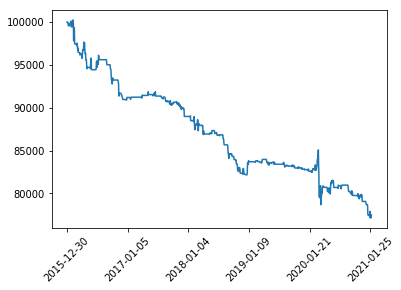

In [23]:
plot_returns(last_dates, last_portfolio_values)

In [24]:
"""
Variant 3b
- Begin each trade on either US market open or Asian market open
- Regressions are done for all data collected in lookback window

For each row:
    stock_open, stock_close, (assess condition 1), adr_open, adr_close, (assess condition 2)
    If not condition 2 - No action taken: 
        After first 2 events, Assess condition 1 (right before the US market opens ~ 9.29AM EST)
        If condition 1:
            Place trade on current and next row (First trade ADR on US market open, then trade stock on Asian market open)
    If not condition 1 - No action taken:
        After next 2 events occur, assess condition 2
        If condition 2:
            Place trade on next row (First trade ADR on Asian market open, then trade stock on US market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date, when the Asian market opens
"""
def pairs_trade_v3b(merged_df, lookback = 100, cash = 100000, entry_cond1_val = 1, entry_cond2_val = 1, 
                    exit_cond1_val = 0, exit_cond2_val = 0, stop_loss_cond1 = 3, stop_loss_cond2 = 3, 
                    start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                    borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2,
                    sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    # We assume lookback is given in terms of days
    lookback *= 2
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    holding_period = None
    trade_type = None
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash, prev_adr_pos = cash, adr_pos
    diff_record_bid = deque(maxlen = lookback)
    diff_record_ask = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []
    enter_cond1, exit_cond1, enter_cond2, exit_cond2 = False, False, False, False

    for index, row in merged_df.iterrows():

        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                portfolio_values.append(prev_cash + prev_adr_pos*merged_df.loc[index - 1, 'adr_close'] + stock_pos*(row['stock_open']/row['avg_ask_non_us_at']))
            
            # Before US Market Opens
            diff_record_bid.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
            diff_record_ask.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
            if len(diff_record_bid) == lookback and row["date"] >= start_date and row["date"] <= end_date:
                if stock_pos > 0:
                    holding_period += 1
                    cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
                prev_cash, prev_adr_pos = cash, adr_pos
                    
                ask_mean = np.array(diff_record_ask).mean()
                bid_std = np.array(diff_record_bid).std()
                ask_std = np.array(diff_record_ask).std()
                # If a concurrent trade is not already being placed
                if not (enter_cond2 or exit_cond2):
                    enter_cond1 = (diff_record_bid[-1] > ask_mean + entry_cond1_val*bid_std
                                   and diff_record_bid[-1] <= ask_mean + stop_loss_cond1*bid_std
                                   and stock_pos == 0 and adr_pos == 0)
                    exit_cond1 = ((diff_record_ask[-1] < ask_mean + exit_cond1_val*ask_std
                                  or diff_record_bid[-1] > ask_mean + stop_loss_cond1*bid_std
                                  or (holding_period == maximum_holding_period and trade_type == 1))
                                  and stock_pos > 0 and adr_pos < 0)
                    
                    if enter_cond1:
                        portfolio_value_before_entering = cash
                        adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                        stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                        units = int(min((0.5*cash)/row['adr_close_per_unit'],
                                        (0.5*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                        adr_volume, 
                                        stock_volume))
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                        
                        temp_risk_lookback = min(risk_lookback, index)
                        stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                        adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                        sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                        if (var > portfolio_value_before_entering*var_limit or 
                            max_drawdown_abs > max_drawdown_limit*starting_cash or 
                            sigma > portfolio_value_before_entering*sigma_limit):
                            frac = min((portfolio_value_before_entering*var_limit)/var, 
                                       (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                      (portfolio_value_before_entering*sigma_limit)/sigma)
                            units = int(frac*units)
                            if units == 0:
                                enter_cond1 = False
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"]) 
                        if units != 0:
                            adr_pos -= adr_quantity
                            adr_px = row['adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            stock_pos += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity
                            prev_cash, prev_adr_pos = cash, adr_pos
                            holding_period = 0
                            trade_type = 1
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")

                    elif exit_cond1:

                        adr_px = row['adr_open']*long_multiplier
                        cash -= abs(adr_pos)*adr_px
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                        stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                        cash += stock_pos*stock_px
                        trade_records.append("Closing positions:\n")
                        # Times in EST
                        trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {row['date']}\n")
                        trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                        stock_pos, adr_pos = 0, 0
                        holding_period = None
                        trade_type = None
                        prev_cash, prev_adr_pos = cash, adr_pos
                        if cash > portfolio_value_before_entering:
                            hits.append(1)
                        else:
                            hits.append(0)
                        
            # Before Asian Market Opens
            diff_record_bid.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
            diff_record_ask.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])
            # The 2nd trade of condition 2 falls on the next day
            if len(diff_record_bid) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                ask_mean = np.array(diff_record_ask).mean()
                bid_std = np.array(diff_record_bid).std()
                ask_std = np.array(diff_record_ask).std()
                # If a concurrent trade is not already being placed
                if not (enter_cond1 or exit_cond1):
                    enter_cond2 = (diff_record_bid[-1] > ask_mean + entry_cond2_val*bid_std
                                   and diff_record_bid[-1] <= ask_mean + stop_loss_cond2*bid_std
                                   and stock_pos == 0 and adr_pos == 0)
                    exit_cond2 = ((diff_record_ask[-1] < ask_mean + exit_cond2_val*ask_std
                                  or diff_record_bid[-1] > ask_mean + stop_loss_cond2*bid_std
                                  or (holding_period == maximum_holding_period and trade_type == 2))
                                  and stock_pos > 0 and adr_pos < 0)

                    if enter_cond2:
                        portfolio_value_before_entering = cash
                        adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                        stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                        units = int(min((0.5*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                        (0.5*cash)/(row['stock_close_per_unit']/row['avg_bid_us_before']), 
                                        adr_volume, 
                                        stock_volume))
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                        temp_risk_lookback = min(risk_lookback, index)
                        stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                        adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                        sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                        if (var > portfolio_value_before_entering*var_limit or 
                            max_drawdown_abs > max_drawdown_limit*starting_cash or 
                            sigma > portfolio_value_before_entering*sigma_limit):
                            frac = min((portfolio_value_before_entering*var_limit)/var, 
                                       (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                      (portfolio_value_before_entering*sigma_limit)/sigma)
                            units = int(frac*units)
                            if units == 0:
                                enter_cond2 = False
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])  
                        if units != 0:
                            stock_pos += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                            prev_cash, prev_adr_pos = cash, adr_pos

                            adr_pos -= adr_quantity
                            adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                            cash += adr_quantity*adr_px
                            holding_period = 0
                            trade_type = 2
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                    elif exit_cond2:
                        stock_px_fx = merged_df.loc[index+1,'stock_open']
                        stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']*short_multiplier
                        cash += stock_pos*stock_px
                        # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                        prev_cash, prev_adr_pos = cash, adr_pos
                        
                        adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                        cash -= abs(adr_pos)*adr_px
                        trade_records.append("Closing positions:\n")
                        # Times in EST
                        trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                        trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")
                        stock_pos, adr_pos = 0, 0
                        holding_period = None
                        trade_type = None
                        if cash > portfolio_value_before_entering:
                            hits.append(1)
                        else:
                            hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash

    return ret, trade_records, portfolio_values, hits, dates

In [25]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v3b, 'logs3b.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 6.5%, Hit Ratio: 85.71%, Max Drawdown: 3.45%
Country: Australia, ADR_Stock: GENE_GTG, Return: 23.54%, Hit Ratio: 83.54%, Max Drawdown: 6.4%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 5.34%, Hit Ratio: 75.93%, Max Drawdown: 2.39%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 24.87%, Hit Ratio: 76.09%, Max Drawdown: 0.32%
Country: Australia, ADR_Stock: JHX_JHX, Return: 0.52%, Hit Ratio: 42.37%, Max Drawdown: 0.42%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 13.48%, Hit Ratio: 70.24%, Max Drawdown: 0.26%
Country: Australia, ADR_Stock: MESO_MSB, Return: 11.76%, Hit Ratio: 79.82%, Max Drawdown: 6.86%
Country: Australia, ADR_Stock: PLL_PLL, Return: 26.78%, Hit Ratio: 77.27%, Max Drawdown: 13.58%
Country: Australia, ADR_Stock: WBK_WBC, Return: -0.06%, Hit Ratio: 41.96%, Max Drawdown: 3.44%
Country: China, ADR_Stock: ACH_2600, Return: -0.52%, Hit Ratio: 48.63%, Max Drawdown: 0.77%
Country: China, ADR_Stock: BGNE_6160, Return: 27.81

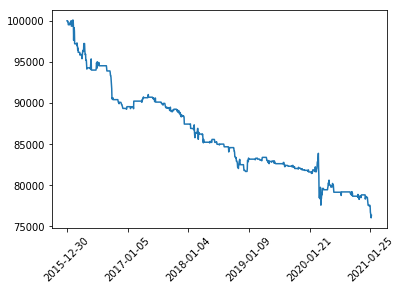

In [26]:
plot_returns(last_dates, last_portfolio_values)

In [27]:
list_pairs_copy = list_pairs.copy()
list_pairs_aus = list_pairs[:9]
list_pairs_chi = list_pairs[9:18]
list_pairs_jap = list_pairs[18:]

In [28]:
list_pairs = list_pairs_aus
list_pairs = list_pairs_chi
list_pairs = list_pairs_jap
#list_pairs = list_pairs_copy

# Global Variant 1

In [89]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry"] = 1
    ind_hp_dict["exit"] = 1
    ind_hp_dict["stop_loss"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_dict = {}
diff_record_ask_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [90]:
iter_dict

{('Japan', 'CAJ_7751'): {'index': 0},
 ('Japan', 'HMC_7267'): {'index': 0},
 ('Japan', 'IX_8591'): {'index': 0},
 ('Japan', 'MFG_8411'): {'index': 0},
 ('Japan', 'MUFG_8306'): {'index': 0},
 ('Japan', 'NMR_8604'): {'index': 0},
 ('Japan', 'SMFG_8316'): {'index': 0},
 ('Japan', 'SONY_6758'): {'index': 0},
 ('Japan', 'TAK_4502'): {'index': 0},
 ('Japan', 'TM_7203'): {'index': 0}}

In [93]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    print(current_date)
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        print(prev_value)
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                print(adr)
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                print(prev_value)
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
                print(prev_value)
                print("\n")
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid = diff_record_bid_dict[(country, adr)]
                    diff_record_ask = diff_record_ask_dict[(country, adr)]
                    diff_record_bid.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
                    diff_record_ask.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])

                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    if len(diff_record_bid) < lookback or row["date"] < start_date or merged_df.loc[index+1, "date"] > end_date:
                        continue

                    ask_mean = np.array(diff_record_ask).mean()
                    bid_std = np.array(diff_record_bid).std()
                    ask_std = np.array(diff_record_ask).std()

                    entry = hp_dict[(country, adr)]["entry"]
                    exit = hp_dict[(country, adr)]["exit"]
                    stop_loss = hp_dict[(country, adr)]["stop_loss"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]

                    if diff_record_bid[-1] > ask_mean + entry*bid_std and diff_record_bid[-1] <= ask_mean + stop_loss*bid_std:
                        if stock_pos == 0 and adr_pos == 0:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   

                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                    # Liquidation condition
                    elif (diff_record_ask[-1] < ask_mean + exit*ask_std or 
                          diff_record_bid[-1] > ask_mean + stop_loss*bid_std or 
                          holding_period == maximum_holding_period):
                        if stock_pos > 0 and adr_pos < 0 : 
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None

                #iter_dict[(country, adr)]["has_current_date"] = False

2015-04-13
2015-04-14
2015-04-15
2015-04-16
2015-04-17
2015-04-21
2015-04-22
2015-04-23
2015-04-24
2015-04-27
2015-04-28
2015-04-30
2015-05-01
2015-05-07
2015-05-08
2015-05-11
2015-05-12
2015-05-13
2015-05-14
2015-05-15
2015-05-18
2015-05-19
2015-05-20
2015-05-21
2015-05-22
2015-05-26
2015-05-27
2015-05-28
2015-05-29
2015-06-01
2015-06-02
2015-06-03
2015-06-04
2015-06-05
2015-06-08
2015-06-09
2015-06-10
2015-06-11
2015-06-12
2015-06-15
2015-06-16
2015-06-17
2015-06-18
2015-06-19
2015-06-22
2015-06-23
2015-06-24
2015-06-25
2015-06-26
2015-06-29
2015-06-30
2015-07-01
2015-07-02
2015-07-06
2015-07-07
2015-07-08
2015-07-09
2015-07-10
2015-07-14
2015-07-15
2015-07-16
2015-07-17
2015-07-21
2015-07-22
2015-07-23
2015-07-24
2015-07-27
2015-07-28
2015-07-29
2015-07-30
2015-07-31
2015-08-03
2015-08-04
2015-08-05
2015-08-06
2015-08-07
2015-08-10
2015-08-11
2015-08-12
2015-08-13
2015-08-14
2015-08-17
2015-08-18
2015-08-19
2015-08-20
2015-08-21
2015-08-24
2015-08-25
2015-08-26
2015-08-27
2015-08-28

2016-04-25
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-04-26
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-04-27
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-04-28
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-05-02
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-05-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-05-09
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-05-10
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-05-11
975396.361585

975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-05
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-07
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-08
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-09
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-12
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-13
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2016-12-14
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7

2017-05-25
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-05-26
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-05-30
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-05-31
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-06-01
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-06-02
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-06-05
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-06-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-06-07
975396.361585

TM_7203
975396.3615852691
975396.3615852691


2017-09-27
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-09-28
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-09-29
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-10-02
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-10-03
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-10-04
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-10-05
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2017-10-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.361585269



2018-03-27
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-03-28
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-03-29
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-04-02
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-04-03
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-04-04
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-04-05
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-04-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-04-09
975396.3615

975396.3615852691


2018-10-29
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-10-30
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-10-31
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-11-01
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-11-02
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-11-05
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-11-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018-11-07
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2018

975396.3615852691
975396.3615852691


2019-04-16
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-17
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-18
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-22
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-23
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-24
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-25
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-04-26
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396


TM_7203
975396.3615852691
975396.3615852691


2019-11-14
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-15
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-18
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-19
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-20
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-21
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-22
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2019-11-25
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.36158526

2020-07-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-07
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-08
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-09
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-10
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-13
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-14
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-15
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-07-16
975396.361585

975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2020-12-30
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-04
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-05
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-06
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-07
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-08
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-12
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7203
975396.3615852691
975396.3615852691


2021-01-13
975396.3615852691
CAJ_7751
975396.3615852691
975396.3615852691


TM_7

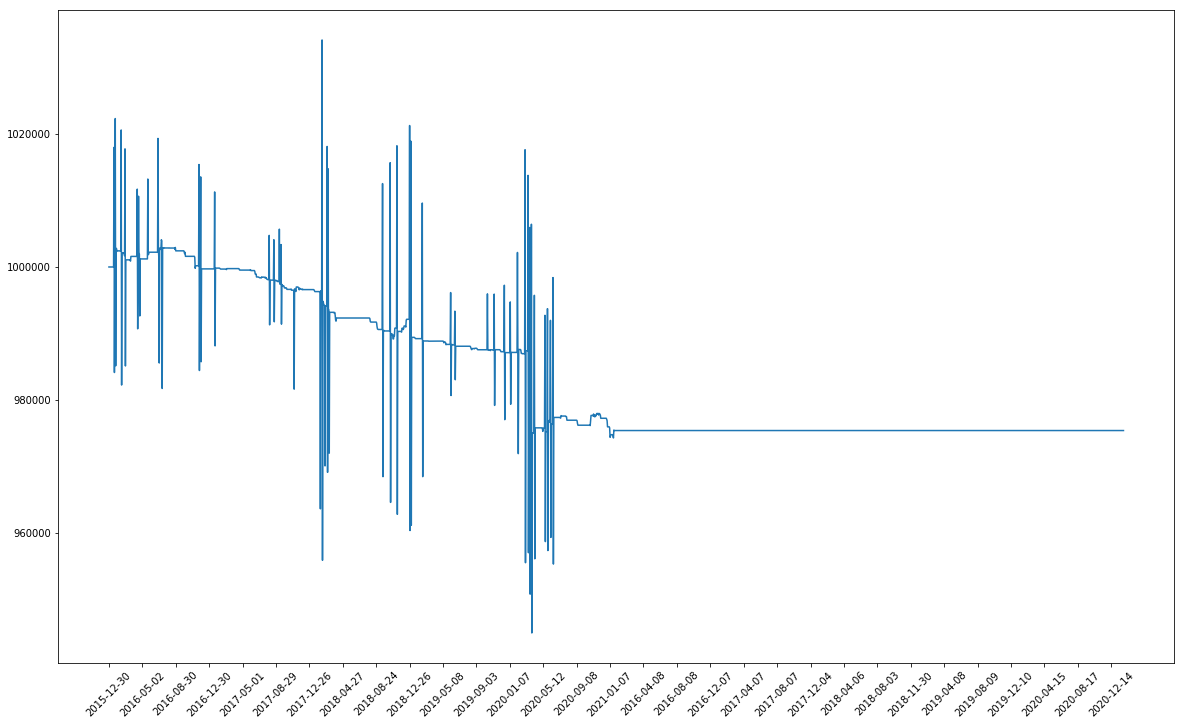

Opening positions:
We bought 657 shares of underlying stock (7751) at the price of 27.697920247990627 USD (3263.2599999999998 foreign dollars) on 2016-01-21
We sold 657 shares of ADR (CAJ) at the price of 27.92205 on 2016-01-22
Opening positions:
We bought 1756 shares of underlying stock (7203) at the price of 56.007573703912335 USD (6598.592 foreign dollars) on 2016-01-21
We sold 878 shares of ADR (TM) at the price of 114.99489 on 2016-01-22
Closing positions:
We sold 657 shares of underlying stock (7751) at the price of 28.06567668150757 USD (3331.665 foreign dollars) on 2016-01-22
We bought 657 shares of ADR (CAJ) at the price of 27.917889999999996 on 2016-01-25
Closing positions:
We sold 1756 shares of underlying stock (7203) at the price of 57.873360881177675 USD (6870.123 foreign dollars) on 2016-01-22



In [94]:
# plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))

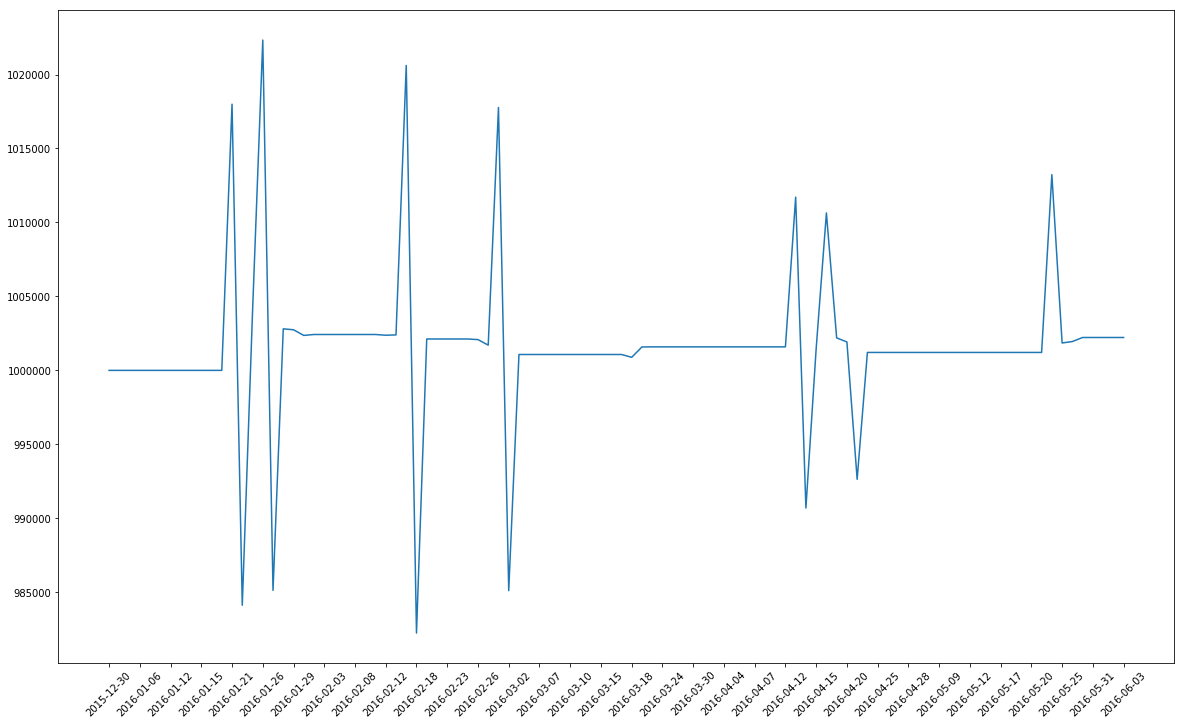

In [80]:
def plot_returns(dates, portfolio_values, num_xticks = 30):
    fig, ax = plt.subplots(figsize = (20,12))
    plt.plot(portfolio_values)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)// num_xticks)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), rotation = 45)
    plt.show();
    
plot_returns(dates[:100], portfolio_values[:100])

In [95]:
print(dates[10:30])
print(portfolio_values[10:30])
print("".join(trade_records[:10]))

['2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28', '2016-01-29', '2016-02-01', '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-12', '2016-02-16', '2016-02-17']
[1000000.0, 1000000.0, 1017993.7577477419, 984126.1119282733, 1003922.6711682733, 1022329.1178881059, 985130.9559873482, 1002808.6959873482, 1002745.2180209765, 1002363.9266405469, 1002425.285140547, 1002425.285140547, 1002425.285140547, 1002425.285140547, 1002425.285140547, 1002425.285140547, 1002425.285140547, 1002375.5486149788, 1002397.0657410827, 1020610.6702557473]
Opening positions:
We bought 657 shares of underlying stock (7751) at the price of 27.697920247990627 USD (3263.2599999999998 foreign dollars) on 2016-01-21
We sold 657 shares of ADR (CAJ) at the price of 27.92205 on 2016-01-22
Opening positions:
We bought 1756 shares of underlying stock (7203) at the price of 56.007573703912335 USD (6598.592 

# Global Variant 2

In [67]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry"] = 1
    ind_hp_dict["exit"] = 1
    ind_hp_dict["stop_loss"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_dict = {}
diff_record_ask_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    #iter_dict[(country, adr)]["has_current_date"] = False
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [65]:
for i in range(1, len(datelist)):
# for i in range(1, 10):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid = diff_record_bid_dict[(country, adr)]
                    diff_record_ask = diff_record_ask_dict[(country, adr)]
                    diff_record_bid.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
                    diff_record_ask.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
                    
                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    if len(diff_record_bid) < lookback or row["date"] < start_date or row["date"] > end_date:
                        continue

                    ask_mean = np.array(diff_record_ask).mean()
                    bid_std = np.array(diff_record_bid).std()
                    ask_std = np.array(diff_record_ask).std()

                    entry = hp_dict[(country, adr)]["entry"]
                    exit = hp_dict[(country, adr)]["exit"]
                    stop_loss = hp_dict[(country, adr)]["stop_loss"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]

                    if diff_record_bid[-1] > ask_mean + entry*bid_std and diff_record_bid[-1] <= ask_mean + stop_loss*bid_std:
                        if stock_pos == 0 and adr_pos == 0:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                                
                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = row['adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                    # Liquidation condition
                    elif (diff_record_ask[-1] < ask_mean + exit*ask_std or 
                          diff_record_bid[-1] > ask_mean + stop_loss*bid_std or 
                          holding_period == maximum_holding_period):
                        if stock_pos > 0 and adr_pos < 0 : 
                            adr_px = row['adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px

                            
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None

                #iter_dict[(country, adr)]["has_current_date"] = False

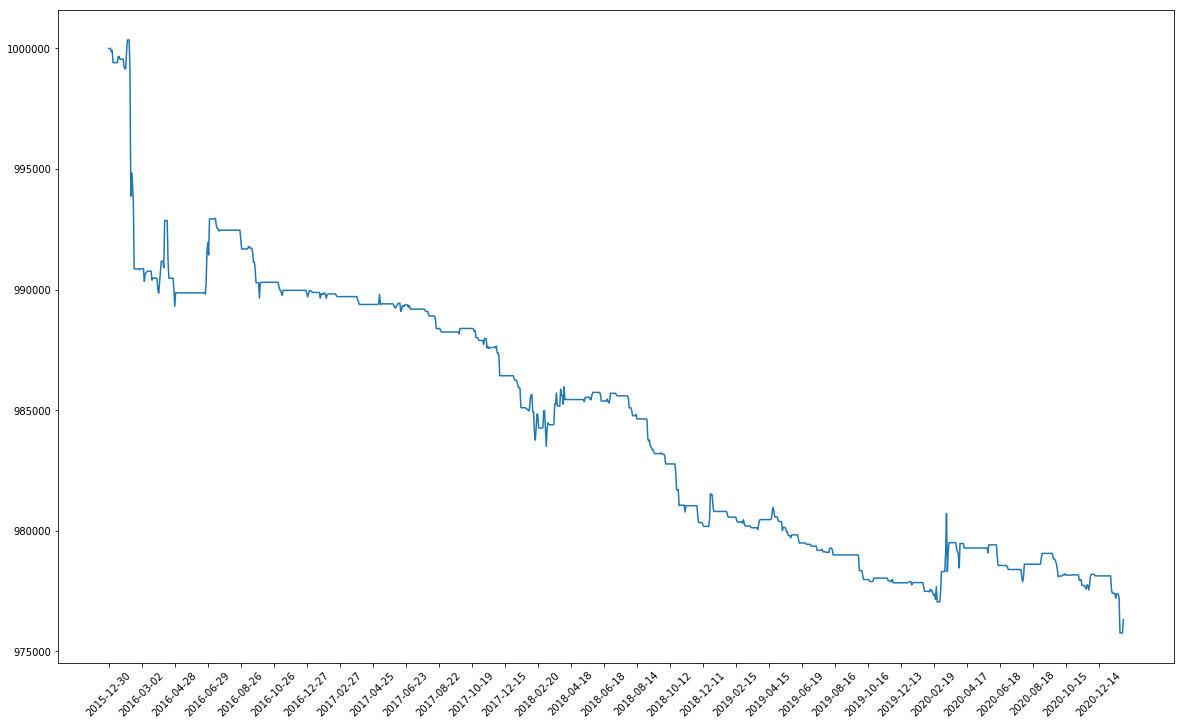

Opening positions:
We sold 466 shares of ADR (TM) at the price of 118.45142999999999 on 2016-01-06
We bought 932 shares of underlying stock (7203) at the price of 59.30545138744664 USD (7029.021999999999 foreign dollars) on 2016-01-06
Closing positions:
We bought 466 shares of ADR (TM) at the price of 116.43631999999998 on 2016-01-08
We sold 932 shares of underlying stock (7203) at the price of 57.66934844587423 USD (6793.2 foreign dollars) on 2016-01-08
Opening positions:
We sold 695 shares of ADR (TM) at the price of 112.18769999999999 on 2016-01-20
We bought 1390 shares of underlying stock (7203) at the price of 56.06819473401939 USD (6563.556999999999 foreign dollars) on 2016-01-20
Opening positions:
We sold 739 shares of ADR (CAJ) at the price of 27.2727 on 2016-01-21



In [66]:
# plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))

# Global Variant 3(a)

In [35]:
df_dict = {}
for (country, adr) in list_pairs:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry_cond1_val"] = 1
    ind_hp_dict["entry_cond2_val"] = 1
    ind_hp_dict["exit_cond1_val"] = 0
    ind_hp_dict["exit_cond2_val"] = 0
    ind_hp_dict["stop_loss_cond1"] = 3
    ind_hp_dict["stop_loss_cond2"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_bid_cond1_dict = {}
diff_record_ask_cond1_dict = {}
diff_record_bid_cond2_dict = {}
diff_record_ask_cond2_dict = {}
for (country, adr) in list_pairs:
    diff_record_bid_cond1_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_cond1_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_bid_cond2_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_ask_cond2_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    positions[(country, adr)]["trade_type"] = None
    
conditions = {}
for (country, adr) in list_pairs:
    conditions[(country, adr)] = {}
    conditions[(country, adr)]["enter_cond1"] = False
    conditions[(country, adr)]["exit_cond1"] = False
    conditions[(country, adr)]["enter_cond2"] = False
    conditions[(country, adr)]["exit_cond2"] = False
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 1000000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [36]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                prev_value += positions[(country, adr)]["stock_pos"]*(row['stock_open']/row['avg_ask_non_us_at'])
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_bid_cond1 = diff_record_bid_cond1_dict[(country, adr)]
                    diff_record_ask_cond1 = diff_record_ask_cond1_dict[(country, adr)]
                    diff_record_bid_cond2 = diff_record_bid_cond2_dict[(country, adr)]
                    diff_record_ask_cond2 = diff_record_ask_cond2_dict[(country, adr)]
                    diff_record_bid_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_bid_us_before'])
                    diff_record_ask_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_ask_us_before'])
                    diff_record_bid_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
                    diff_record_ask_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])

                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    
                    # row["date"] is between start_date (inclusive) and end_date (inclusive)
                    if len(diff_record_bid) < lookback or row["date"] < start_date or row["date"] > end_date:
                        continue

                    ask_mean_cond1 = np.array(diff_record_ask_cond1).mean()
                    bid_std_cond1 = np.array(diff_record_bid_cond1).std()
                    ask_std_cond1 = np.array(diff_record_ask_cond1).std()
                    ask_mean_cond2 = np.array(diff_record_ask_cond2).mean()
                    bid_std_cond2 = np.array(diff_record_bid_cond2).std()
                    ask_std_cond2 = np.array(diff_record_ask_cond2).std()

                    entry_cond1_val = hp_dict[(country, adr)]["entry_cond1_val"]
                    entry_cond2_val = hp_dict[(country, adr)]["entry_cond2_val"]
                    exit_cond1_val = hp_dict[(country, adr)]["exit_cond1_val"]
                    exit_cond2_val = hp_dict[(country, adr)]["exit_cond2_val"]
                    stop_loss_cond1 = hp_dict[(country, adr)]["stop_loss_cond1"]
                    stop_loss_cond2 = hp_dict[(country, adr)]["stop_loss_cond2"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    trade_type = positions[(country, adr)]["trade_type"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]
                    
                    enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                    exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                    enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                    exit_cond2 = conditions[(country, adr)]["exit_cond2"]
                    
                    if not (enter_cond2 or exit_cond2):
                        enter_cond1 = (diff_record_bid_cond1[-1] > ask_mean_cond1 + entry_cond1_val*bid_std_cond1 
                                       and diff_record_bid_cond1[-1] <= ask_mean_cond1 + stop_loss_cond1*bid_std_cond1
                                       and stock_pos == 0 and adr_pos == 0)
                        exit_cond1 = ((diff_record_ask_cond1[-1] < ask_mean_cond1 + exit_cond1_val*ask_std_cond1 
                                      or diff_record_bid_cond1[-1] > ask_mean_cond1 + stop_loss_cond1*bid_std_cond1
                                      or (holding_period == maximum_holding_period and trade_type == 1))
                                      and stock_pos > 0 and adr_pos < 0)
                        
                        if enter_cond1:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                                
                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = row['adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash -= stock_px*stock_quantity

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                        elif exit_cond1:
                            adr_px = row['adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px

                            
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            
                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None
                            positions[(country, adr)]["trade_type"] = None
                            
                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                            
                        conditions[(country, adr)]["enter_cond1"] = enter_cond1
                        conditions[(country, adr)]["exit_cond1"] = exit_cond1
                            
                    if not (enter_cond1 or exit_cond1) and merged_df.loc[index+1, "date"] <= end_date:
                        
                        # Check and possibly trade condition 2
                        enter_cond2 = (diff_record_bid_cond2[-1] > ask_mean_cond2 + entry_cond2_val*bid_std_cond2 
                               and diff_record_bid_cond2[-1] <= ask_mean_cond2 + stop_loss_cond2*bid_std_cond2
                               and stock_pos == 0 and adr_pos == 0)
                        exit_cond2 = ((diff_record_ask_cond2[-1] < ask_mean_cond2 + exit_cond2_val*ask_std_cond2 
                              or diff_record_bid_cond2[-1] > ask_mean_cond2 + stop_loss_cond2*bid_std_cond2
                              or (holding_period == maximum_holding_period and trade_type == 2))
                              and stock_pos > 0 and adr_pos < 0)
                        
                        if enter_cond2:

                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    enter_cond2 = False
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                            if units != 0:
                                stock_pos += stock_quantity
                                positions[(country, adr)]["stock_pos"] += stock_quantity
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash -= stock_px*stock_quantity
                                # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                prev_cash = cash
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                adr_pos -= adr_quantity
                                positions[(country, adr)]["adr_pos"] -= adr_quantity
                                adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                cash += adr_quantity*adr_px

                                positions[(country, adr)]["holding_period"] = 0
                                positions[(country, adr)]["trade_type"] = 2
                                trade_records.append("Opening positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                                trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                        # Liquidation condition
                        elif exit_cond2:
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            stock_px = stock_px_fx/merged_df.loc[index+1,'avg_ask_non_us_at']
                            cash += stock_pos*stock_px
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                            prev_cash = cash
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None
                            positions[(country, adr)]["trade_type"] = None
                            
                        conditions[(country, adr)]["enter_cond2"] = enter_cond2
                        conditions[(country, adr)]["exit_cond2"] = exit_cond2

In [37]:
    for index, row in merged_df.iterrows():
                    
        if index+1 < len(merged_df) and index > 0:
                    
                if enter_cond1:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].mean()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].mean()/row["stock_num_per_unit"])
                    units = int(min((0.5*cash)/row['adr_close_per_unit'],
                                    (0.5*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])*short_multiplier
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    stock_temp = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((stock_temp["stock_open"]/stock_temp["avg_ask_non_us_at"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            enter_cond1 = False
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                    if units != 0:
                        adr_pos -= adr_quantity
                        adr_px = row['adr_open']
                        cash += adr_quantity*adr_px

                        stock_pos += stock_quantity
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                        stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
                        cash -= stock_px*stock_quantity
                        prev_cash, prev_adr_pos = cash, adr_pos
                        holding_period = 0
                        trade_type = 1
                        
                        trade_records.append("Opening positions:\n")
                        # Times in EST
                        trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({stock_px_fx} foreign dollars) on {row['date']}\n")
   




ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

# Global Variant 3(b)